In [6]:
import sqlite3
import pandas as pd
import seaborn as sns
import ast
import math

In [29]:
db_path = '../../data/vcs-agent-evaluation-metadata.db'

conn = sqlite3.connect(db_path)

query = "SELECT * FROM vcs_agent_evaluation_metadata"
evaluation_df = pd.read_sql_query(query, conn)

conn.close()

print(f"Loaded {len(evaluation_df)} records from the database")

Loaded 180 records from the database


In [8]:
evaluation_df.head()

,sample_id,agent_solution,ground_truth,is_solved,llm_responses,scenario_type,execution_time_ms
0,spring_projects_spring_framework_file_commit_c...,commit 782a438fe8d173ddf415c2ae80a854eb8f7d4dd...,commit 8ff801648de53fe8ca743c09132f07fd167248b...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,33328
1,apache_hbase_file_commit_chain_0138,commit 5b26be045391b757d32cacecbadb6bbd8240af8...,commit 07357a2f8439b02affe35a50deb23f46dd6cfe3...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,42346
2,minestom_minestom_file_commit_chain_0008,commit 6c3737d0b0df5cabc9097aee73835051b6e4a59...,commit 1a013728fd54dde4e0ab5749a96307e7483d69c...,1,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,80908
3,apache_incubator_hugegraph_file_commit_chain_0001,commit d299eb15caeddc57e8c7b4b2ba23711669ac3b0...,commit e586b9a1a6d70d8a42a5804c89c9026fc37d74f...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,15550
4,spring_cloud_spring_cloud_dataflow_file_commit...,commit b9e37da90d55493682e7e3f31b4c1a0168b6943...,commit c8a76a111851e9794a10c10e3fb1a8978297ea6...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,20196


In [10]:
# Load the baseline dataset from CSV
baseline_df = pd.read_csv('../../data/git_good_bench_lite.csv')

# Display basic information about the baseline dataframe
print(f"Loaded {len(baseline_df)} records from the baseline dataset")

# Join the evaluation dataframe with the baseline dataframe
# Note: For file_commit_chain samples, there will be two entries in evaluation_df for each entry in baseline_df
merged_df = pd.merge(
    evaluation_df,
    baseline_df,
    left_on='sample_id',
    right_on='id',
    how='left'
)

# Display information about the merged dataframe
print(f"Merged dataframe has {len(merged_df)} records")
print(f"Number of samples with missing baseline data: {merged_df['id'].isna().sum()}")


Loaded 120 records from the baseline dataset
Merged dataframe has 180 records
Number of samples with missing baseline data: 0


In [11]:
# Check if 'Unnamed: 0' column exists and drop it if it does
if 'Unnamed: 0' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Unnamed: 0'])

In [12]:
merged_df.head()

,sample_id,agent_solution,ground_truth,is_solved,llm_responses,scenario_type,execution_time_ms,id,name,default_branch,license,stargazers,created_at,topics,programming_language,scenario,sample_type,project_size,difficulty
0,spring_projects_spring_framework_file_commit_c...,commit 782a438fe8d173ddf415c2ae80a854eb8f7d4dd...,commit 8ff801648de53fe8ca743c09132f07fd167248b...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,33328,spring_projects_spring_framework_file_commit_c...,spring-projects/spring-framework,main,Apache License 2.0,55286,2010-12-08T04:04:45,framework;spring;spring-framework,java,{'file': 'org.springframework.core/src/test/ja...,file_commit_chain,large,medium
1,apache_hbase_file_commit_chain_0138,commit 5b26be045391b757d32cacecbadb6bbd8240af8...,commit 07357a2f8439b02affe35a50deb23f46dd6cfe3...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,42346,apache_hbase_file_commit_chain_0138,apache/hbase,master,Apache License 2.0,5127,2014-05-23T07:00:07,database;hbase;java,java,{'file': 'hbase-server/src/test/java/org/apach...,file_commit_chain,huge,medium
2,minestom_minestom_file_commit_chain_0008,commit 6c3737d0b0df5cabc9097aee73835051b6e4a59...,commit 1a013728fd54dde4e0ab5749a96307e7483d69c...,1,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,80908,minestom_minestom_file_commit_chain_0008,minestom/minestom,master,Apache License 2.0,2113,2019-08-03T01:22:27,java;minecraft;minecraft-api;minecraft-perform...,java,{'file': 'src/main/java/net/minestom/server/ut...,file_commit_chain,medium,hard
3,apache_incubator_hugegraph_file_commit_chain_0001,commit d299eb15caeddc57e8c7b4b2ba23711669ac3b0...,commit e586b9a1a6d70d8a42a5804c89c9026fc37d74f...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,15550,apache_incubator_hugegraph_file_commit_chain_0001,apache/incubator-hugegraph,master,Apache License 2.0,2559,2018-07-18T03:30:20,big-data;database;graph;graph-database;graphdb...,java,{'file': 'hugegraph-core/src/main/java/com/bai...,file_commit_chain,large,easy
4,spring_cloud_spring_cloud_dataflow_file_commit...,commit b9e37da90d55493682e7e3f31b4c1a0168b6943...,commit c8a76a111851e9794a10c10e3fb1a8978297ea6...,0,"[{""response_1"": {""evaluation_result"": ""HISTORY...",file_commit_chain_scenario-rebase,20196,spring_cloud_spring_cloud_dataflow_file_commit...,spring-cloud/spring-cloud-dataflow,main,Apache License 2.0,1076,2015-07-21T08:56:11,batch-processing;cloud-native;datapipelines;mi...,java,{'file': 'spring-cloud-dataflow-server/src/tes...,file_commit_chain,large,hard


## Computing solve rate

Overall solve rate: 21.11%
Total samples: 180
Solved samples: 38


Solve rate by scenario_type:
                                   solve_rate  total_samples  solved_samples
scenario_type                                                               
file_commit_chain_scenario-rebase   26.666667             60              16
file_commit_chain_scenario-chunk    23.333333             60              14
merge                               13.333333             60               8


Solve rate by sample_type:
                   solve_rate  total_samples  solved_samples
sample_type                                                 
file_commit_chain   25.000000            120              30
merge               13.333333             60               8


Solve rate by difficulty:
            solve_rate  total_samples  solved_samples
difficulty                                           
easy         19.672131             61              12
hard         19.354839             62              12
me

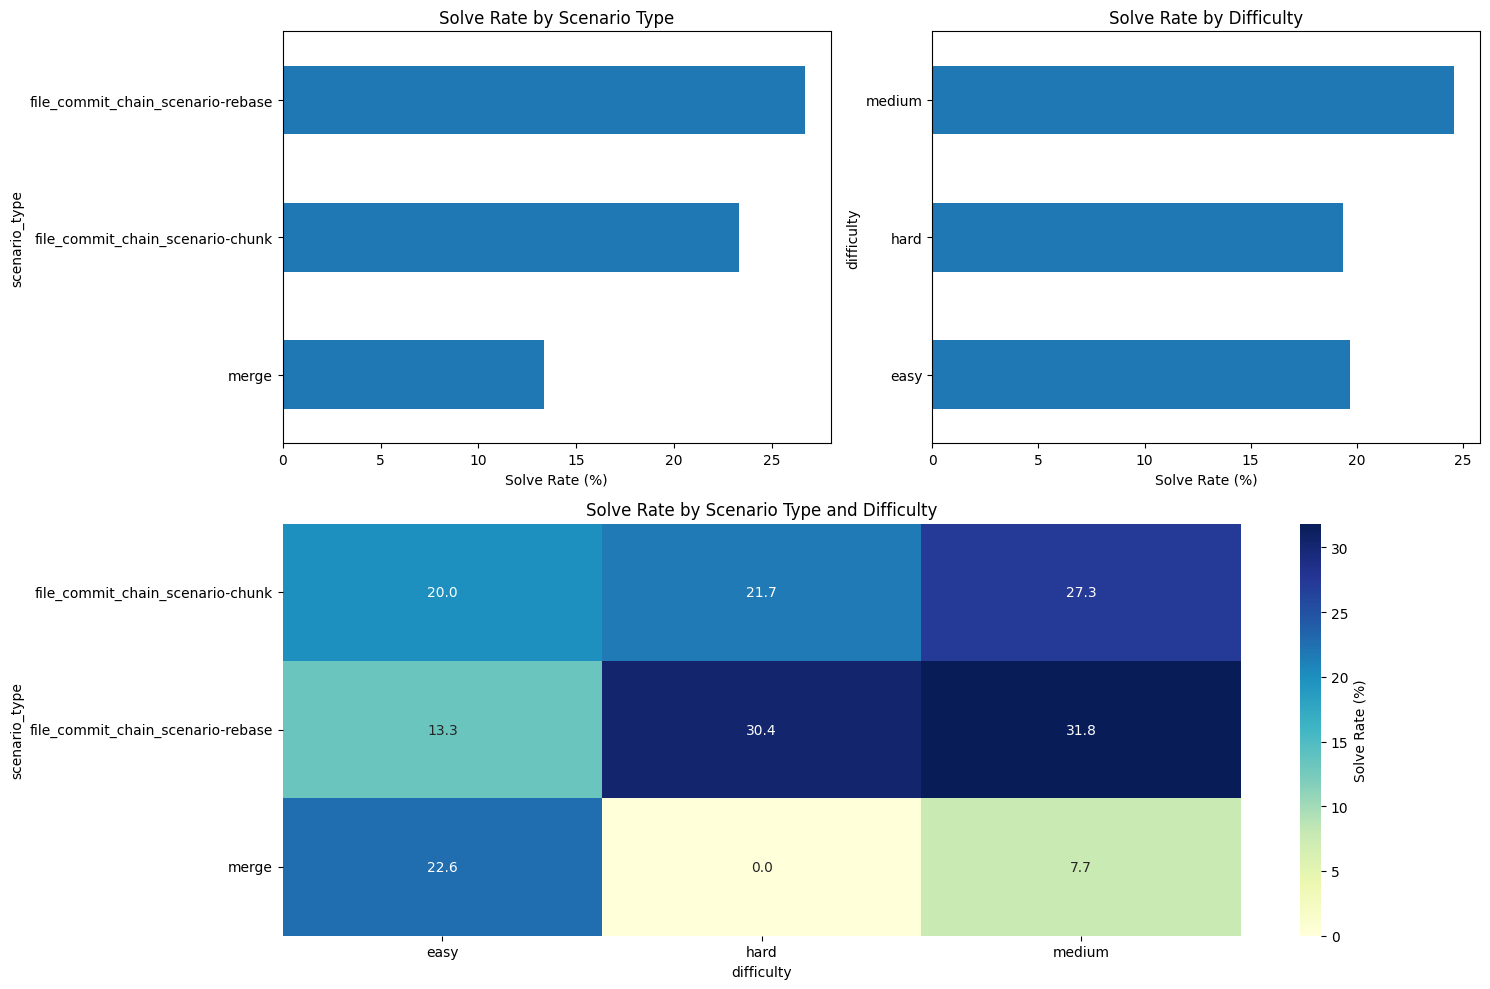

In [13]:
# Calculate overall solve rate
overall_solve_rate = merged_df['is_solved'].mean() * 100
print(f"Overall solve rate: {overall_solve_rate:.2f}%")
print(f"Total samples: {len(merged_df)}")
print(f"Solved samples: {merged_df['is_solved'].sum()}")
print("\n" + "="*50 + "\n")

# Solve rate by scenario_type
print("Solve rate by scenario_type:")
scenario_type_stats = merged_df.groupby('scenario_type').agg(
    solve_rate=('is_solved', 'mean'),
    total_samples=('is_solved', 'count'),
    solved_samples=('is_solved', 'sum')
)
scenario_type_stats['solve_rate'] = scenario_type_stats['solve_rate'] * 100
print(scenario_type_stats.sort_values('solve_rate', ascending=False))
print("\n" + "="*50 + "\n")

# Solve rate by sample_type (from the baseline dataset)
if 'sample_type' in merged_df.columns:
    print("Solve rate by sample_type:")
    sample_type_stats = merged_df.groupby('sample_type').agg(
        solve_rate=('is_solved', 'mean'),
        total_samples=('is_solved', 'count'),
        solved_samples=('is_solved', 'sum')
    )
    sample_type_stats['solve_rate'] = sample_type_stats['solve_rate'] * 100
    print(sample_type_stats.sort_values('solve_rate', ascending=False))
    print("\n" + "="*50 + "\n")

# Solve rate by difficulty
print("Solve rate by difficulty:")
difficulty_stats = merged_df.groupby('difficulty').agg(
    solve_rate=('is_solved', 'mean'),
    total_samples=('is_solved', 'count'),
    solved_samples=('is_solved', 'sum')
)
difficulty_stats['solve_rate'] = difficulty_stats['solve_rate'] * 100
print(difficulty_stats.sort_values('difficulty'))
print("\n" + "="*50 + "\n")

# Solve rate by scenario_type and difficulty
print("Solve rate by scenario_type and difficulty:")
scenario_difficulty_stats = merged_df.groupby(['scenario_type', 'difficulty']).agg(
    solve_rate=('is_solved', 'mean'),
    total_samples=('is_solved', 'count'),
    solved_samples=('is_solved', 'sum')
)
scenario_difficulty_stats['solve_rate'] = scenario_difficulty_stats['solve_rate'] * 100
print(scenario_difficulty_stats)
print("\n" + "="*50 + "\n")

# Solve rate by scenario_type and programming language
if 'programming_language' in merged_df.columns:
    print("Solve rate by scenario_type and programming language:")
    scenario_language_stats = merged_df.groupby(['scenario_type', 'programming_language']).agg(
        solve_rate=('is_solved', 'mean'),
        total_samples=('is_solved', 'count'),
        solved_samples=('is_solved', 'sum')
    )
    scenario_language_stats['solve_rate'] = scenario_language_stats['solve_rate'] * 100
    print(scenario_language_stats)
    print("\n" + "="*50 + "\n")

# If sample_type exists, show solve rate by sample_type and difficulty
if 'sample_type' in merged_df.columns:
    print("Solve rate by sample_type and difficulty:")
    sample_difficulty_stats = merged_df.groupby(['sample_type', 'difficulty']).agg(
        solve_rate=('is_solved', 'mean'),
        total_samples=('is_solved', 'count'),
        solved_samples=('is_solved', 'sum')
    )
    sample_difficulty_stats['solve_rate'] = sample_difficulty_stats['solve_rate'] * 100
    print(sample_difficulty_stats)
    print("\n" + "="*50 + "\n")

# Visualize the results
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(15, 10))

# Plot solve rate by scenario_type
plt.subplot(2, 2, 1)
scenario_type_stats['solve_rate'].sort_values().plot(kind='barh')
plt.title('Solve Rate by Scenario Type')
plt.xlabel('Solve Rate (%)')
plt.tight_layout()

# Plot solve rate by difficulty
plt.subplot(2, 2, 2)
difficulty_stats['solve_rate'].plot(kind='barh')
plt.title('Solve Rate by Difficulty')
plt.xlabel('Solve Rate (%)')
plt.tight_layout()

# Plot solve rate by scenario_type and difficulty as a heatmap
plt.subplot(2, 1, 2)
heatmap_data = scenario_difficulty_stats['solve_rate'].unstack()
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.1f', cbar_kws={'label': 'Solve Rate (%)'})
plt.title('Solve Rate by Scenario Type and Difficulty')
plt.tight_layout()

plt.show()


In [14]:
merged_df['scenario'] = merged_df['scenario'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df['llm_responses'] = merged_df['llm_responses'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [15]:
merged_df['purity'] = merged_df['scenario'].apply(lambda x: x['purity'] if 'purity' in x else math.nan)

In [16]:
merged_df[(merged_df['scenario_type'] == 'file_commit_chain_scenario-chunk') & (merged_df['difficulty'] == 'easy')].loc[:, ['sample_id', 'difficulty', 'purity', 'llm_responses']]

,sample_id,difficulty,purity,llm_responses
105,apache_incubator_hugegraph_file_commit_chain_0001,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
106,activiti_activiti_file_commit_chain_0001,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
107,apache_hive_file_commit_chain_0002,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
108,google_guava_file_commit_chain_0017,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
109,fate_grand_automata_fga_file_commit_chain_0001,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
110,oss_review_toolkit_ort_file_commit_chain_0166,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
111,oss_review_toolkit_ort_file_commit_chain_0038,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
112,oss_review_toolkit_ort_file_commit_chain_0355,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
113,oss_review_toolkit_ort_file_commit_chain_0327,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...
114,oss_review_toolkit_ort_file_commit_chain_0299,easy,1.0,[{'response_1': {'evaluation_result': 'HISTORY...


In [17]:
merged_df[(merged_df['scenario_type'] == 'file_commit_chain_scenario-chunk') & (merged_df['agent_solution'].str.contains('Agent was t'))].loc[:, ['sample_id', 'is_solved', 'difficulty', 'purity', 'llm_responses', 'agent_solution']]

,sample_id,is_solved,difficulty,purity,llm_responses,agent_solution
63,spring_cloud_spring_cloud_dataflow_file_commit...,0,hard,0.71,[{'response_1': {'evaluation_result': 'HISTORY...,Agent was terminated by Ideformer due to an un...
85,http4k_http4k_file_commit_chain_0013,0,hard,0.51,[{'response_1': {'evaluation_result': 'HISTORY...,Agent was terminated by Ideformer due to an un...
99,nvidia_ai_iot_torch2trt_file_commit_chain_0001,0,medium,0.89,[{'response_1': {'evaluation_result': 'HISTORY...,Agent was terminated by Ideformer due to an un...
103,montrealcorpustools_montreal_forced_aligner_fi...,0,medium,0.99,[{'response_1': {'evaluation_result': 'HISTORY...,Agent was terminated by Ideformer due to an un...


In [18]:
merged_df[(merged_df['scenario_type'] == 'file_commit_chain_scenario-chunk')].loc[174, 'llm_responses']

KeyError: 174

In [19]:
# Filter rows where 'commit' is not found in 'agent_solution'
# First, convert agent_solution to string if it's not already
merged_df['agent_solution'] = merged_df['agent_solution'].astype(str)

# Then filter rows where 'commit' is not in agent_solution and scenario_type is file_commit_chain_scenario-chunk
filtered_df = merged_df[
    (merged_df['scenario_type'] == 'file_commit_chain_scenario-chunk') & 
    (~merged_df['agent_solution'].str.contains('commit'))
]

# Display the filtered dataframe
filtered_df[['sample_id', 'is_solved', 'difficulty', 'purity']]['difficulty'].value_counts()


difficulty
hard      2
medium    2
Name: count, dtype: int64

## Computing success rate

In [20]:
merged_df.loc[~(merged_df['agent_solution'].str.contains('Error running scenario') | 
          merged_df['agent_solution'].str.contains('Could not initiate rebase') |
          merged_df['agent_solution'].str.contains('Agent was terminated by agent hosting platform due to an unexpected error')), 'is_success'] = 1
merged_df.loc[(merged_df['agent_solution'].str.contains('Error running scenario') | 
          merged_df['agent_solution'].str.contains('Could not initiate rebase') |
          merged_df['agent_solution'].str.contains('Agent was terminated by agent hosting platform due to an unexpected error')), 'is_success'] = 0

In [21]:
merged_df['is_success'].value_counts()

is_success
1.0    158
0.0     22
Name: count, dtype: int64

Success rate by scenario type:
                       scenario_type  success_rate
0   file_commit_chain_scenario-chunk      0.933333
1  file_commit_chain_scenario-rebase      0.933333
2                              merge      0.766667


Success rate by difficulty:
  difficulty  success_rate
0       easy      0.901639
1       hard      0.854839
2     medium      0.877193


Success rate by difficulty across scenario types:
                       scenario_type difficulty  success_rate
0   file_commit_chain_scenario-chunk       easy      1.000000
1   file_commit_chain_scenario-chunk       hard      0.913043
2   file_commit_chain_scenario-chunk     medium      0.909091
3  file_commit_chain_scenario-rebase       easy      1.000000
4  file_commit_chain_scenario-rebase       hard      0.956522
5  file_commit_chain_scenario-rebase     medium      0.863636
6                              merge       easy      0.806452
7                              merge       hard      0.625000
8                

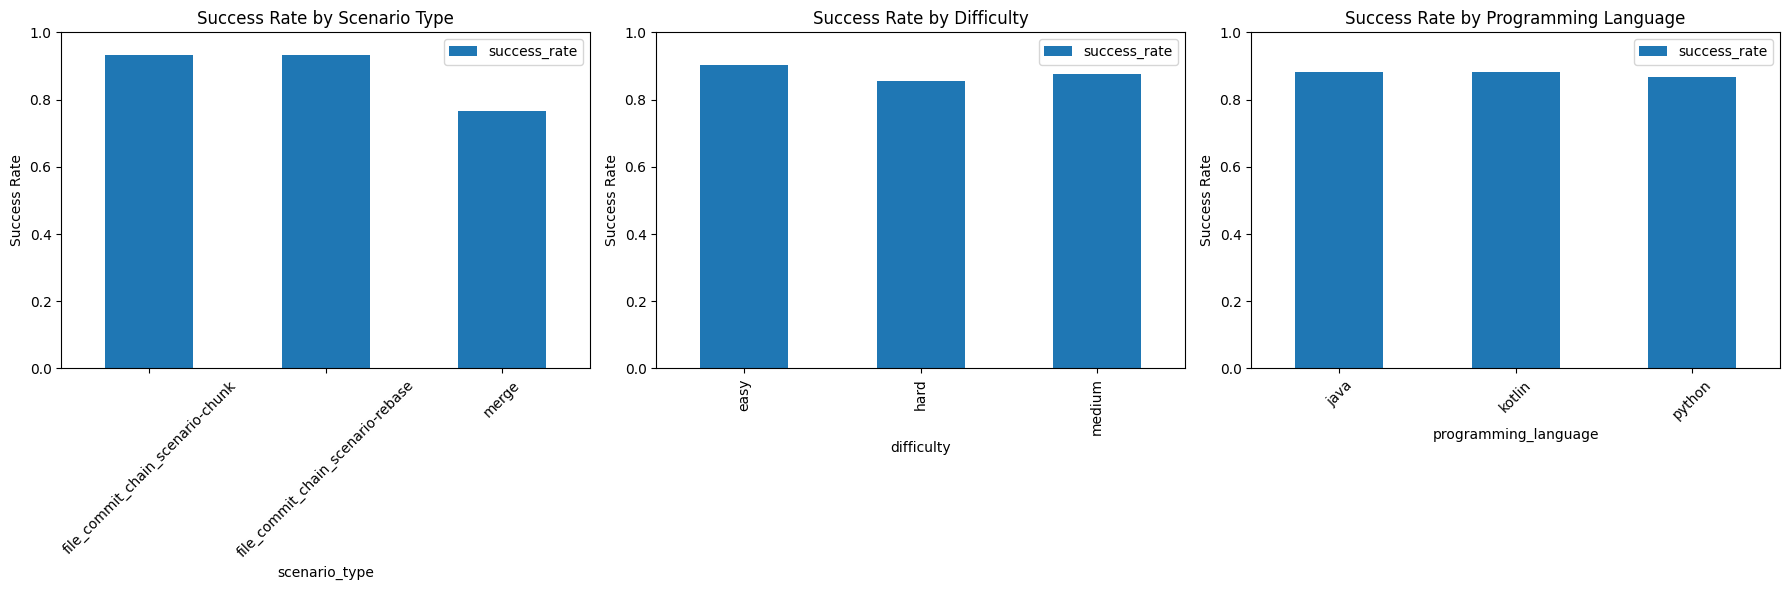

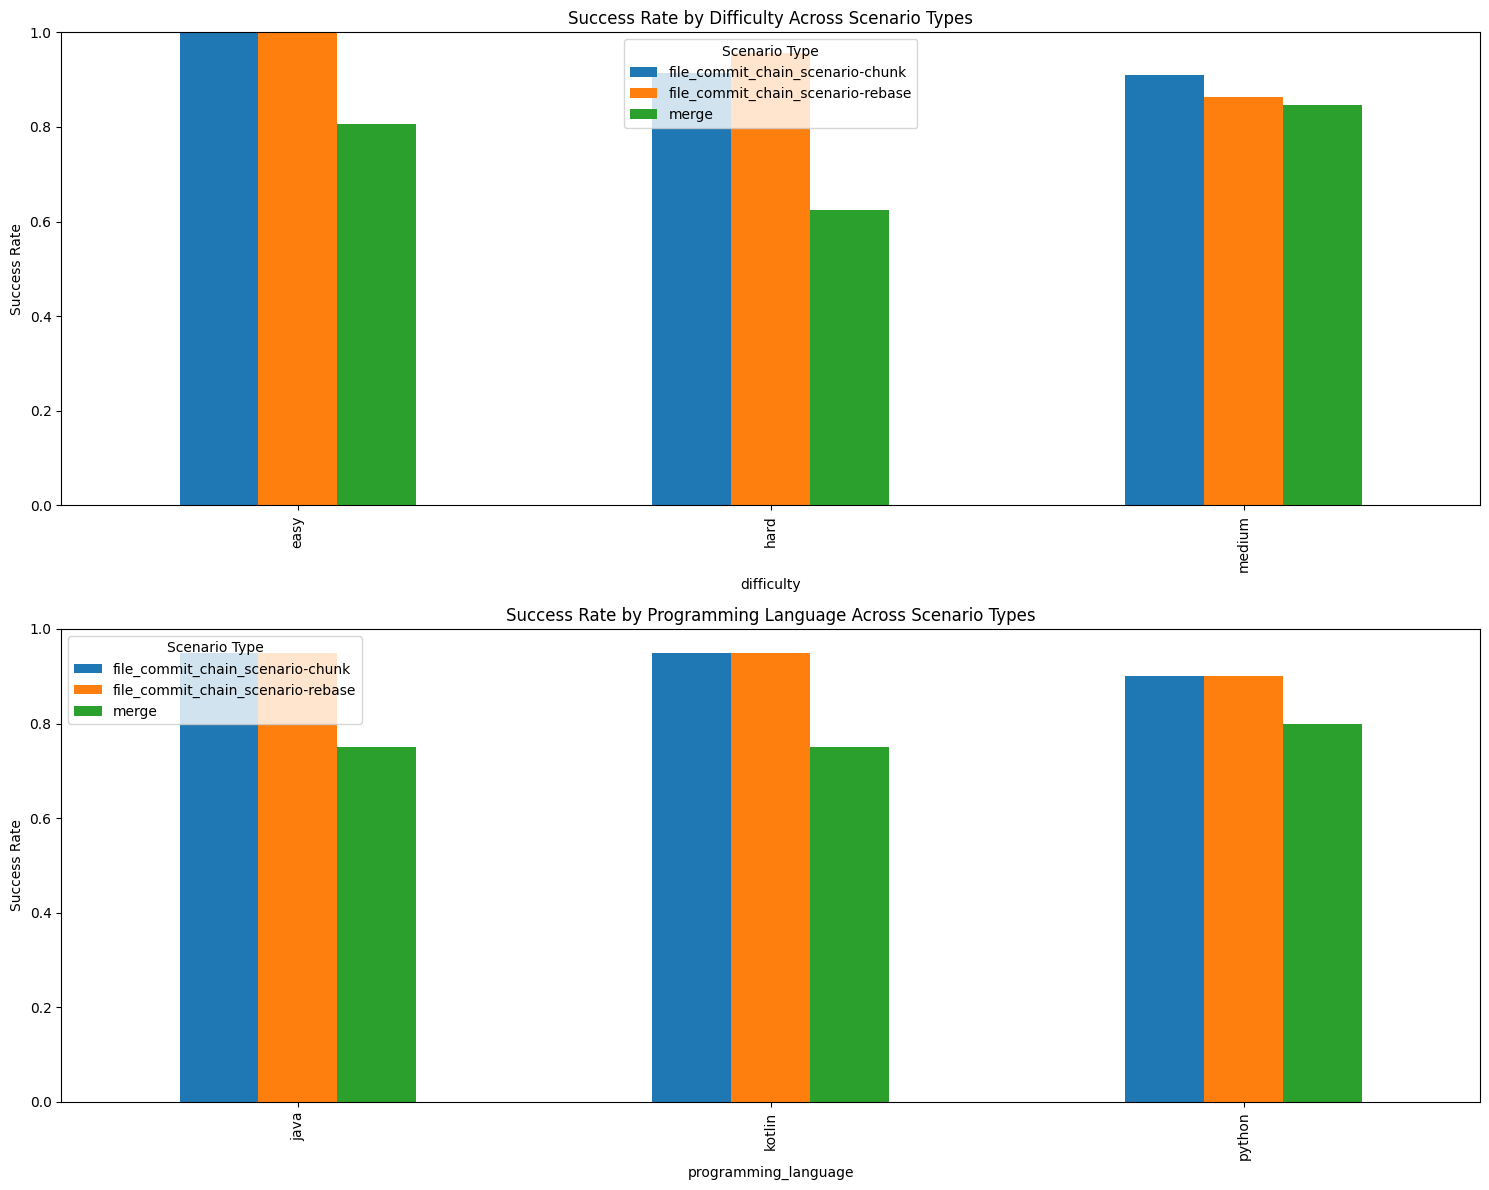

In [22]:
# Calculate success rate by scenario_type
success_by_scenario = merged_df.groupby('scenario_type')['is_success'].mean().reset_index()
success_by_scenario.columns = ['scenario_type', 'success_rate']
print("Success rate by scenario type:")
print(success_by_scenario)
print("\n")

# Calculate success rate by difficulty
success_by_difficulty = merged_df.groupby('difficulty')['is_success'].mean().reset_index()
success_by_difficulty.columns = ['difficulty', 'success_rate']
print("Success rate by difficulty:")
print(success_by_difficulty)
print("\n")

# Calculate success rate by difficulty across scenario types
success_by_difficulty_scenario = merged_df.groupby(['scenario_type', 'difficulty'])['is_success'].mean().reset_index()
success_by_difficulty_scenario.columns = ['scenario_type', 'difficulty', 'success_rate']
print("Success rate by difficulty across scenario types:")
print(success_by_difficulty_scenario)
print("\n")

# Calculate success rate by programming language
success_by_language = merged_df.groupby('programming_language')['is_success'].mean().reset_index()
success_by_language.columns = ['programming_language', 'success_rate']
print("Success rate by programming language:")
print(success_by_language)
print("\n")

# Calculate success rate by programming language across scenario types
success_by_language_scenario = merged_df.groupby(['scenario_type', 'programming_language'])['is_success'].mean().reset_index()
success_by_language_scenario.columns = ['scenario_type', 'programming_language', 'success_rate']
print("Success rate by programming language across scenario types:")
print(success_by_language_scenario)
print("\n")

# Calculate overall success rate
overall_success_rate = merged_df['is_success'].mean()
print(f"Overall success rate: {overall_success_rate:.2f}")

# Create visualizations
import matplotlib.pyplot as plt

# Set up the figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot success rate by scenario type
success_by_scenario.plot(x='scenario_type', y='success_rate', kind='bar', ax=axes[0])
axes[0].set_title('Success Rate by Scenario Type')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Success Rate')
axes[0].tick_params(axis='x', rotation=45)

# Plot success rate by difficulty
success_by_difficulty.plot(x='difficulty', y='success_rate', kind='bar', ax=axes[1])
axes[1].set_title('Success Rate by Difficulty')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Success Rate')

# Plot success rate by programming language
success_by_language.plot(x='programming_language', y='success_rate', kind='bar', ax=axes[2])
axes[2].set_title('Success Rate by Programming Language')
axes[2].set_ylim(0, 1)
axes[2].set_ylabel('Success Rate')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create additional visualizations for cross-analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot success rate by difficulty across scenario types
pivot_diff = success_by_difficulty_scenario.pivot(index='difficulty', columns='scenario_type', values='success_rate')
pivot_diff.plot(kind='bar', ax=ax1)
ax1.set_title('Success Rate by Difficulty Across Scenario Types')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Success Rate')
ax1.legend(title='Scenario Type')

# Plot success rate by programming language across scenario types
pivot_lang = success_by_language_scenario.pivot(index='programming_language', columns='scenario_type', values='success_rate')
pivot_lang.plot(kind='bar', ax=ax2)
ax2.set_title('Success Rate by Programming Language Across Scenario Types')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Success Rate')
ax2.legend(title='Scenario Type')

plt.tight_layout()
plt.show()
